# compute basic statistics with single trajectories 

In [1]:
import os
from glob import glob
import pickle

import numpy as np
import xarray as xr
import dask.bag as db
import pandas as pd
#import geopandas
import datetime

import scipy.ndimage as im

from matplotlib import pyplot as plt
%matplotlib inline
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

from mitequinox.utils import coriolis, dfdy
import mitequinox.drifters as edr
import mitequinox.sigp as sigp

data_dir = '/work/ALT/swot/aval/syn/drifters/'

In [2]:
from dask_jobqueue import PBSCluster
#cluster = PBSCluster(cores=1, walltime='12:00:00', memory='10GB')
cluster = PBSCluster(cores=1, walltime='01:00:00', memory='10GB')
#w = cluster.scale(40)
w = cluster.scale(10) # postprocessing

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)
#client = Client()

In [4]:
cluster

In [9]:
#client.close()
cluster.close()

---

## lifetimes

In [5]:
files = sorted(glob(data_dir+'single/*.p'))
#files = files[:500]
print('%d single trajectories' %len(files))

12287 single trajectories


In [6]:
b = ( db.from_sequence(files[:], npartitions=1000) \
              .map(lambda f: pickle.load(open(f, 'rb'))) )

In [7]:
ld = b.take(1)[0]

In [8]:
#def get_stats(d, T, overlap):
def get_stats(d):
    ID = d[1]
    _drop_col = ['GAP','RMSGAP']
    d = d[0].drop(columns=_drop_col)
    #
    # for position filtering
    d = edr.compute_vector(d)
    d['U2'] = d['U']**2
    d['V2'] = d['V']**2
    #
    d = d[~pd.isnull(d.index)]
    #
    dm = d.mean(axis=0)
    dm = edr.compute_lonlat(dm)
    life_time = d.index[-1]-d.index[0]
    tm = d.index[0]+life_time*.5
    #
    return {'id': ID, 'lon': dm.LON, 'lat': dm.LAT, 'time': tm, 
            'u2': dm.U2, 'v2': dm.V2, 'life_time': life_time}

out = get_stats(ld)
out

{'id': 2578,
 'lon': -51.310380565479704,
 'lat': 43.713846833612195,
 'time': Timestamp('2005-07-31 20:00:00'),
 'u2': 0.09204098853027082,
 'v2': 0.07136083195250138,
 'life_time': Timedelta('214 days 00:00:00')}

In [9]:
df = b.map(get_stats).to_dataframe()

In [10]:
df.head()

,id,lat,life_time,lon,time,u2,v2
0,2578,43.713847,214 days 00:00:00,-51.310381,2005-07-31 20:00:00,0.092041,0.071361
1,2582,45.668585,178 days 16:00:00,-53.127868,2005-07-13 08:00:00,0.020667,0.021284
2,2583,46.872077,42 days 15:00:00,-49.714996,2004-06-17 23:30:00,0.008425,0.006466
3,2592,46.872831,46 days 02:00:00,-53.544498,2001-05-24 09:00:00,0.009173,0.011273
4,2612,46.961192,169 days 16:00:00,-50.341422,2005-07-09 09:00:00,0.015278,0.011982


In [11]:
df_pd = df.compute()

Text(0.5, 0, '[years]')

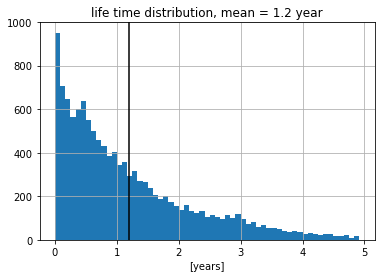

In [15]:
mean_life_time = df_pd.life_time.apply(lambda x: float(x.days/360.)).mean()

fig, ax = plt.subplots(1,1)
df_pd.life_time.apply(lambda x: float(x.days/360.)).hist(bins=np.arange(0,5,1./12), ax=ax)
ax.axvline(x=mean_life_time, color='k')
ax.set_title('life time distribution, mean = %.1f year'%mean_life_time)
ax.set_xlabel('[years]')

In [28]:
# bin by year
#year_count = df.groupby(pd.Grouper(freq='Y', key='time')).count().compute()
#year_count.id.plot()
# ! not representative of all drifters deployed per year !

---

## distance travelled over selected time intervals

In [70]:
T = [1, 5, 10, 20, 30] # in days
r_bins = np.arange(0., 2000.,10.)

In [49]:
def get_stats(d, T):
    ID = d[1]
    _drop_col = ['GAP','RMSGAP']
    d = d[0].drop(columns=_drop_col)
    #
    #out = {'id': ID}
    #
    dt = datetime.timedelta(days=T)
    d0, d1 = d.align(d.tshift(freq=-dt),join='inner')
    r = edr.haversine(d0.LON, d0.LAT, d1.LON, d1.LAT)
    #
    #r = r[~pd.isnull(d.index)]
    #
    #rm = r.mean(axis=0)
    #out[t] = rm
    r_binned = pd.cut(r, bins=r_bins).value_counts(sort=False)
    return r_binned.to_dict()

#p0, p0_low = chunk_pair(lp, 20, .5)
#p0_low.head()
out = get_stats(ld, 10)
out

{Interval(10.0, 20.0, closed='right'): 167,
 Interval(20.0, 30.0, closed='right'): 346,
 Interval(30.0, 40.0, closed='right'): 265,
 Interval(40.0, 50.0, closed='right'): 323,
 Interval(50.0, 60.0, closed='right'): 461,
 Interval(60.0, 70.0, closed='right'): 402,
 Interval(70.0, 80.0, closed='right'): 316,
 Interval(80.0, 90.0, closed='right'): 448,
 Interval(90.0, 100.0, closed='right'): 189,
 Interval(100.0, 110.0, closed='right'): 160,
 Interval(110.0, 120.0, closed='right'): 79,
 Interval(120.0, 130.0, closed='right'): 85,
 Interval(130.0, 140.0, closed='right'): 151,
 Interval(140.0, 150.0, closed='right'): 140,
 Interval(150.0, 160.0, closed='right'): 105,
 Interval(160.0, 170.0, closed='right'): 52,
 Interval(170.0, 180.0, closed='right'): 51,
 Interval(180.0, 190.0, closed='right'): 44,
 Interval(190.0, 200.0, closed='right'): 56,
 Interval(200.0, 210.0, closed='right'): 51,
 Interval(210.0, 220.0, closed='right'): 48,
 Interval(220.0, 230.0, closed='right'): 48,
 Interval(230.

In [82]:
for t in T:
    df = b.map(get_stats, t).to_dataframe()
    s = df.sum(axis=0).compute()
    if t==T[0]:
        odf = s.to_frame(name=t)
    else:
        odf[t] = s

In [ ]:
# compute average displacement
r = r_c
dr = odf.index.length
mr={}
for t in T:
    mr[t] = (odf[t]*r*dr).sum(axis=0)/(odf[t]*dr).sum(axis=0)

30
30
30
30
30


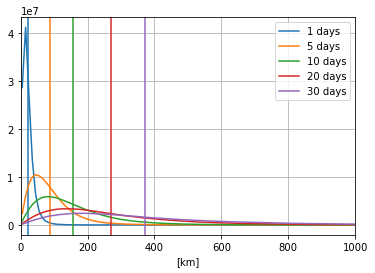

In [107]:
r_c = (r_bins[1:]+r_bins[:-1])*.5

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = plt.subplots(1,1)
for t, c in zip(T, colors):
    ax.plot(r_c, odf[t], color=c, label='%d days'%t)
    ax.axvline(x=mr[t], color=c)
    print('T=%d days: mean displacement = %f.1 km' %(t,mr[t]))
ax.set_xlim(0,1000)
ax.set_xlabel('[km]')
ax.grid()
ax.legend()

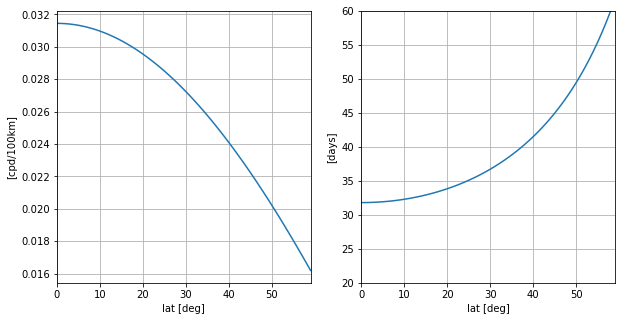

In [19]:
lat = np.arange(0.,60.,1.)
df = pd.DataFrame({'dfdy': pd.Series(dfdy(lat, units='cpd/100km'), index=lat) })
df['Tsep'] = 1/df.dfdy
#
fig, axes = plt.subplots(1,2, figsize=(10,5))
#
ax=axes[0]
df.dfdy.plot(ax=ax)
ax.set_ylabel('[cpd/100km]')
ax.set_xlabel('lat [deg]')
ax.grid()
#
ax=axes[1]
df.Tsep.plot(ax=ax)
ax.set_ylabel('[days]')
ax.set_xlabel('lat [deg]')
ax.set_ylim((20,60))
ax.grid()

---
## map of averaged displacement over a given time interval

In [204]:
lon_bins = np.arange(0., 360., 1.)
lat_bins = np.arange(-90., 90., 1.)

lon_idx = pd.IntervalIndex.from_breaks(lon_bins)
lat_idx = pd.IntervalIndex.from_breaks(lat_bins)
lonlat_idx = pd.MultiIndex.from_product([lon_idx, lat_idx])

In [205]:
def get_stats(d, T):
    #ID = d[1]
    _drop_col = ['GAP','RMSGAP']
    d = d[0].drop(columns=_drop_col)
    #
    #out = {'id': ID}
    #
    dt = datetime.timedelta(days=T)
    d0, d1 = d.align(d.tshift(freq=-dt),join='inner')
    #d0['LON'][d0.LON<0] = d0['LON'][d0.LON<0] + 360.
    d0['LON'][d0.LON<0] = d0['LON'][d0.LON<0].apply(lambda x: x + 360.)
    #
    df = edr.haversine(d0.LON, d0.LAT, d1.LON, d1.LAT).to_frame(name='r')
    #df['ones'] = d0.LAT.apply(lambda x: x*0.+1.)
    df['lon'] = pd.cut(d0.LON, bins=lon_bins)
    df['lat'] = pd.cut(d0.LAT, bins=lat_bins)
    #
    #df = df[(~pd.isnull(d0.LON)) & (~pd.isnull(d1.LON))]
    #df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
    #odf = df.r.groupby([df.lon, df.lat]).sum().to_frame(name='r')
    #odf['N'] = df.ones.groupby([df.lon, df.lat]).sum().fillna(0.)
    odf = ( df.r.groupby([df.lon, df.lat]).agg(['count', 'sum'])
               .reindex(lonlat_idx).fillna(0) )
    #
    #return odf.to_dict()
    return {'count': odf['count'].unstack().values, 
            'sum':odf['sum'].unstack().values}

ld = b.take(10)[-1]
out = get_stats(ld, 30)
out

/home/mp/pontea/mit_equinox/mitequinox/drifters.py:102: RuntimeWarning: invalid value encountered in cos
  np.cos(llat1) * np.cos(llat2) * (np.sin((llon2 - llon1) / 2)) ** 2))


{'count': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'sum': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])}

In [206]:
count = b.map(get_stats, 30).pluck('count').sum().compute()
rsum = b.map(get_stats, 30).pluck('sum').sum().compute()

In [207]:
rmean = xr.DataArray(rsum/count, coords=[lon_idx.mid, lat_idx.mid], dims=['lon','lat'])

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


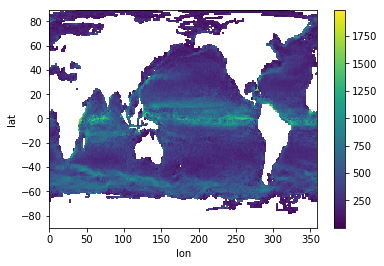

In [208]:
rmean.plot(x='lon', y='lat')

---

## change of coriolis frequency over a time interval

In [10]:
cpd = 86400/2/np.pi

In [26]:
T = [1, 5, 10, 20, 30] # in days
df_bins = np.arange(0.,.3,0.01)
df_c = (df_bins[:-1]+df_bins[1:])*.5

In [27]:
def get_stats(d, T):
    ID = d[1]
    _drop_col = ['GAP','RMSGAP']
    d = d[0].drop(columns=_drop_col)
    #
    #out = {'id': ID}
    #
    dt = datetime.timedelta(days=T)
    d0, d1 = d.align(d.tshift(freq=-dt),join='inner')
    f0 = coriolis(d0.LAT)
    f1 = coriolis(d1.LAT)
    df = (f1-f0)*cpd
    #
    df_binned = pd.cut(df, bins=df_bins).value_counts(sort=False)
    return df_binned.to_dict()

#p0, p0_low = chunk_pair(lp, 20, .5)
#p0_low.head()
out = get_stats(ld, 10)
out

{Interval(0.0, 0.01, closed='right'): 1435,
 Interval(0.01, 0.02, closed='right'): 850,
 Interval(0.02, 0.03, closed='right'): 53,
 Interval(0.03, 0.04, closed='right'): 0,
 Interval(0.04, 0.05, closed='right'): 0,
 Interval(0.05, 0.06, closed='right'): 0,
 Interval(0.06, 0.07, closed='right'): 0,
 Interval(0.07, 0.08, closed='right'): 0,
 Interval(0.08, 0.09, closed='right'): 0,
 Interval(0.09, 0.1, closed='right'): 0,
 Interval(0.1, 0.11, closed='right'): 0,
 Interval(0.11, 0.12, closed='right'): 0,
 Interval(0.12, 0.13, closed='right'): 0,
 Interval(0.13, 0.14, closed='right'): 0,
 Interval(0.14, 0.15, closed='right'): 0,
 Interval(0.15, 0.16, closed='right'): 0,
 Interval(0.16, 0.17, closed='right'): 0,
 Interval(0.17, 0.18, closed='right'): 0,
 Interval(0.18, 0.19, closed='right'): 0,
 Interval(0.19, 0.2, closed='right'): 0,
 Interval(0.2, 0.21, closed='right'): 0,
 Interval(0.21, 0.22, closed='right'): 0,
 Interval(0.22, 0.23, closed='right'): 0,
 Interval(0.23, 0.24, closed='rig

In [28]:
for t in T:
    df = b.map(get_stats, t).to_dataframe()
    s = df.sum(axis=0).compute()
    if t==T[0]:
        odf = s.to_frame(name=t)
    else:
        odf[t] = s

In [29]:
# compute average displacement
df_w = odf.index.length
mdf={}
for t in T:
    mdf[t] = (odf[t]*df_c*df_w).sum(axis=0)/(odf[t]*df_w).sum(axis=0)

T=1 days: mean Coriolis frequency change = 0.005413.1 cpd
T=5 days: mean Coriolis frequency change = 0.012535.1 cpd
T=10 days: mean Coriolis frequency change = 0.019833.1 cpd
T=20 days: mean Coriolis frequency change = 0.030338.1 cpd
T=30 days: mean Coriolis frequency change = 0.038526.1 cpd


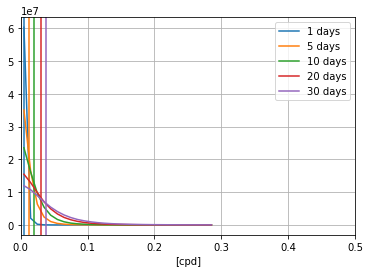

In [30]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = plt.subplots(1,1)
for t, c in zip(T, colors):
    ax.plot(df_c, odf[t], color=c, label='%d days'%t)
    ax.axvline(x=mdf[t], color=c)
    print('T=%d days: mean Coriolis frequency change = %f.1 cpd' %(t,mdf[t]))
ax.set_xlim(0,.5)
ax.set_xlabel('[cpd]')
ax.grid()
ax.legend()

---
## frequency band energy frequency content

In [8]:
h = sigp.gen_filter('inertial', numtaps=24*10, lat=30., domega=0.1/24.)

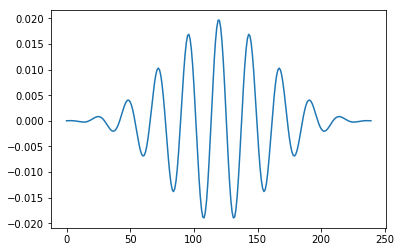

In [9]:
plt.plot(h)

In [10]:
#d = pandas.series()
t = pd.date_range(start='1/1/2018', end='2/1/2018', freq='H')
omega = coriolis(30.)
d = pd.DataFrame(np.sin(omega*(t-t[0]).seconds)).set_index(t)
dfilt = d.apply(lambda x: im.convolve1d(x, h, axis=0, mode='constant'))

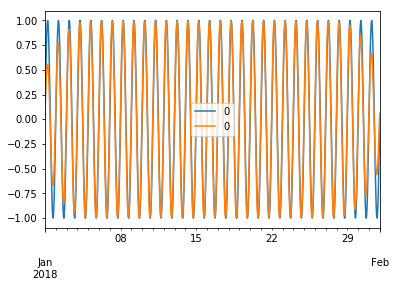

In [11]:
fig, ax = plt.subplots(1,1)
d.plot(ax=ax)
dfilt.plot(ax=ax)

In [18]:
def get_stats(d, T, overlap):
    dt = datetime.timedelta(T)
    #
    ID = d[1]
    _drop_col = ['GAP','RMSGAP']
    d = d[0].drop(columns=_drop_col)
    #
    tmin, tmax = d.index[0], d.index[-1]
    t=tmin
    # for position filtering
    d = edr.compute_vector(d)
    # get rid of NaN and interpolate small temporal gaps (limit parameter)
    d = d[~pd.isnull(d.index)].resample('H').interpolate('linear', limit=24)
    #
    flag=False
    #out = pd.DataFrame([],columns=['r','lon','lat'])
    out = []
    while t+dt<tmax:
        # compute average position
        d_mean = edr.compute_lonlat(d[t:t+dt].mean(axis=0))
        # generate filter
        h = sigp.gen_filter('inertial', numtaps=24*10, 
                            lat=max(5., np.abs(d_mean.LAT)), 
                            domega=0.1/24.)
        dfilt = d.apply(lambda x: im.convolve1d(x, h, axis=0, mode='constant'))
        # mask equatorial points
        if d_mean.LAT<5:
            dfilt[:] = np.NaN
        # compute band filtered KE
        ke = (dfilt.U**2+dfilt.V**2).mean(axis=0)
        out += [{'time': t+dt/2, 'lon': d_mean.LON, 'lat': d_mean.LAT, 'ID': ID, 'ke': ke}]
        t+=dt*(1-overlap)
    #if flag:
    #    out_list = None
    #else:
    #    out_list=[]
    #    for index, row in out.iterrows():
    #        d = row.to_dict()
    #        d['time'] = row.name
    #        d['id0'] = p[2][0]
    #        d['id1'] = p[2][1]            
    #        out_list.append(d)
    #return out
    return out

out = get_stats(b.take(4)[-1], 10, .5)
out

In [22]:
df = b.map(get_stats, 30, 0.5).flatten().to_dataframe()

In [23]:
df.head()

,ID,ke,lat,lon,time
0,2578,0.008698,44.323243,-49.714745,2005-04-30 20:00:00
1,2578,0.008941,43.530715,-51.438485,2005-05-15 20:00:00
2,2578,0.008700,44.320494,-52.045841,2005-05-30 20:00:00
3,2578,0.008370,44.766557,-52.417945,2005-06-14 20:00:00
4,2578,0.008251,44.896791,-52.979619,2005-06-29 20:00:00


In [25]:
df_pd = df.compute()

Text(0.5, 0, '[years]')

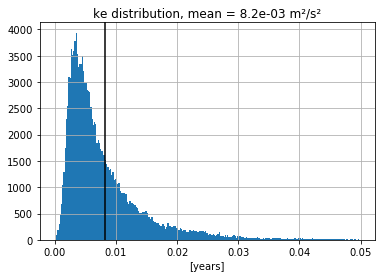

In [33]:
#mean_life_time = df_pd.life_time.apply(lambda x: float(x.days/360.)).mean()
fig, ax = plt.subplots(1,1)
df_pd.ke.hist(bins=np.arange(0,5,.02)*1e-2, ax=ax)
ax.axvline(x=df_pd.ke.mean(axis=0), color='k')
ax.set_title('ke distribution, mean = %.1e m²/s²'%df_pd.ke.mean(axis=0))
ax.set_xlabel('[years]')

In [42]:
ke_bins = np.arange(0,5,.02)*1e-2
lat_bins = np.arange(-90., 90., 1.)

ke_idx = pd.IntervalIndex.from_breaks(ke_bins)
lat_idx = pd.IntervalIndex.from_breaks(lat_bins)
kelat_idx = pd.MultiIndex.from_product([ke_idx, lat_idx])

In [66]:
#ke_cut = pd.cut(df_pd.ke, bins=ke_bins)
#lat_cut = pd.cut(df_pd.lat, bins=lat_bins)
ke_cut = pd.cut(df_pd.ke, bins=ke_idx)
lat_cut = pd.cut(df_pd.lat, bins=lat_idx)
df_bin = (df_pd.ke.groupby([ke_cut, lat_cut]).count()
          .reindex(kelat_idx).fillna(0)
          .unstack())

In [67]:
df_bin

,"(-90.0, -89.0]","(-89.0, -88.0]","(-88.0, -87.0]","(-87.0, -86.0]","(-86.0, -85.0]","(-85.0, -84.0]","(-84.0, -83.0]","(-83.0, -82.0]","(-82.0, -81.0]","(-81.0, -80.0]",...,"(79.0, 80.0]","(80.0, 81.0]","(81.0, 82.0]","(82.0, 83.0]","(83.0, 84.0]","(84.0, 85.0]","(85.0, 86.0]","(86.0, 87.0]","(87.0, 88.0]","(88.0, 89.0]"
"(0.0, 0.0002]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(0.0002, 0.0004]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,7.0,7.0,11.0
"(0.0004, 0.0006]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,9.0,5.0,17.0,8.0,6.0,7.0,16.0,12.0,10.0
"(0.0006, 0.0008]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,8.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
"(0.0008, 0.001]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,1.0,3.0,2.0,2.0,4.0,2.0,6.0,12.0,4.0
"(0.001, 0.0012]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,6.0,5.0,6.0,11.0,5.0,10.0,3.0,4.0
"(0.0012, 0.0014000000000000002]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,5.0,4.0,10.0,22.0,19.0,14.0,13.0,4.0
"(0.0014000000000000002, 0.0016]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,4.0,3.0,5.0,3.0,6.0,3.0,1.0,3.0,5.0
"(0.0016, 0.0018]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,2.0,4.0,8.0,8.0,7.0,9.0,5.0,2.0
"(0.0018, 0.002]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,2.0,1.0,8.0,15.0,5.0,1.0,0.0,0.0


In [68]:
ke_hist = xr.DataArray(df_bin, coords=[ke_idx.mid, lat_idx.mid], dims=['ke','lat'])

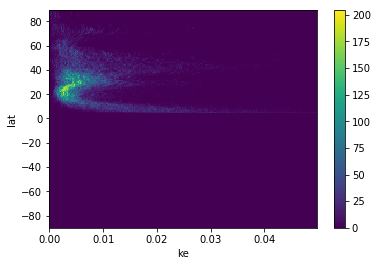

In [70]:
ke_hist.plot(x='ke',y='lat')

---

In [54]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
